In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from gensim.models.coherencemodel import CoherenceModel
from sklearn.manifold import TSNE
# customized lib
import measures

np.random.seed(0)

In [2]:
df = pd.read_csv("./../out.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
df = df.loc[400:1400] # first 1000 segments
df = df.reset_index().drop('index', axis=1)

In [4]:
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim import models

documents = df['segment'].tolist()

doc_tokenized = [simple_preprocess(doc, min_len=1, max_len=2000) for doc in documents]
dictionary = corpora.Dictionary()
BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized]

tfidf = models.TfidfModel(BoW_corpus)
corpus_tfidf = tfidf[BoW_corpus]

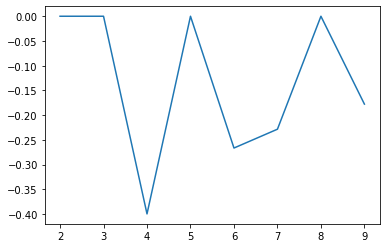

In [5]:
result_num_topic = measures.best_num_topic(corpus_tfidf, dictionary ,10)

Peak at k=5, silhouette_score = 0.5840678969255102


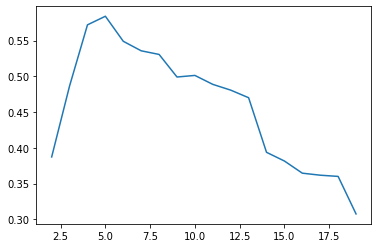

In [6]:
results = measures.best_silhouette_score(AgglomerativeClustering(), corpus = corpus_tfidf, dictionary = dictionary, max_n_clusters = 20, best_num_topic=5)
best_at = list(results['score']).index(results['score'].max())+2
print("Peak at k={}, silhouette_score = {}".format(best_at, results['score'].max()))

In [7]:
lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=best_at)
corpus_lsi = lsi_model[corpus_tfidf] 
cm = CoherenceModel(model=lsi_model, corpus=corpus_lsi, coherence='u_mass')
cm.get_coherence()

0.0

In [8]:
def plot_cluster(corpus, pred):
    tfidf_embedded = TSNE(n_components=2, 
                        perplexity=50, 
                        learning_rate = 'auto',
                        n_iter=1000, 
                        random_state=0).fit_transform(corpus)

    fig = plt.figure(figsize = (10, 10))
    ax = plt.axes()
    plt.scatter(tfidf_embedded[:, 0], tfidf_embedded[:, 1], marker = ".", c = pred)
    plt.show()

Linkage ward

c:[  0   0 196   0   4]	c mapped to 2
d:[  0   0   2   3 195]	d mapped to 4
e:[  5   0   0 195   0]	e mapped to 3
f:[197   0   0   0   3]	f mapped to 0
g:[  0 198   0   2   0]	g mapped to 1


C:\Users\zwang684\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


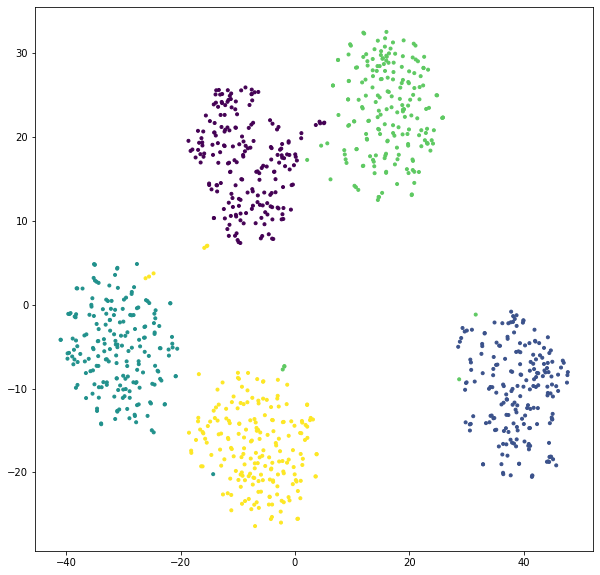

In [9]:
from gensim.matutils import corpus2csc
k = 5
corpus_tfidf_sparse = corpus2csc(corpus_tfidf).T
pred_ward = AgglomerativeClustering(n_clusters=k, linkage="ward").fit_predict(corpus_tfidf_sparse.toarray())

mapped_pred_ward = measures.label_to_cluster_num(pred=pred_ward, k=k, init_label='c')
df['modified_label'] = [mapped_pred_ward[label] for label in df['label']] #map original labels to cluster numbers

plot_cluster(corpus_tfidf_sparse, pred_ward)

In [10]:
kappa = measures.get_kappa(df['modified_label'], pred_ward)
rand_score = measures.get_rand_score(df['modified_label'], pred_ward)
X = np.array([[tup[1] for tup in arr] for arr in corpus_lsi])
silhouette = measures.get_silhouette_score(X, pred_ward)

kappa: 0.97625
rand score: 0.9531764266817871
silhouette score: 0.5194243213629274


Linkage average

Peak at k=5, silhouette_score = 0.5882247836792647


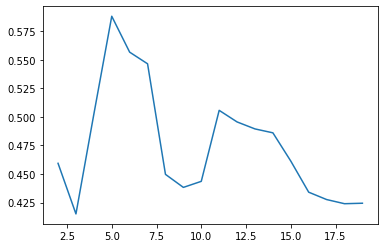

In [11]:
results = measures.best_silhouette_score(AgglomerativeClustering(linkage="average"), corpus = corpus_tfidf, dictionary = dictionary, max_n_clusters = 20, best_num_topic=5)
best_at = list(results['score']).index(results['score'].max())+2
print("Peak at k={}, silhouette_score = {}".format(best_at, results['score'].max()))

In [12]:
pred_avg = AgglomerativeClustering(n_clusters=best_at, linkage="average").fit_predict(corpus_tfidf_sparse.toarray())

mapped_pred_avg = measures.label_to_cluster_num(pred=pred_avg, k=k, init_label='c')
df['modified_label'] = [mapped_pred_avg[label] for label in df['label']] #map original labels to cluster numbers

c:[199   1   0   0   0]	c mapped to 0
d:[  6 191   0   3   0]	d mapped to 1
e:[  6   0 191   3   0]	e mapped to 2
f:[200   0   0   0   0]	f mapped to 0
g:[  0   0   1   0 199]	g mapped to 4


In [13]:
kappa = measures.get_kappa(df['modified_label'], pred_avg)
rand_score = measures.get_rand_score(df['modified_label'], pred_avg)
X = np.array([[tup[1] for tup in arr] for arr in corpus_lsi])
silhouette = measures.get_silhouette_score(X, pred_avg)

kappa: 0.972183588317107
rand score: 0.9539302521669751
silhouette score: 0.23098986462421586


Linkage complete

Peak at k=5, silhouette_score = 0.5344924229755618


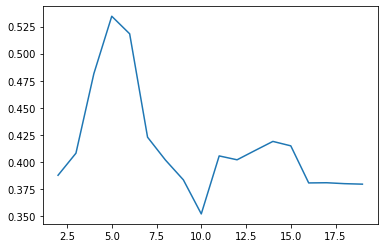

In [14]:
results = measures.best_silhouette_score(AgglomerativeClustering(linkage="complete"), corpus = corpus_tfidf, dictionary = dictionary, max_n_clusters = 20, best_num_topic=5)
best_at = list(results['score']).index(results['score'].max())+2
print("Peak at k={}, silhouette_score = {}".format(best_at, results['score'].max()))

In [15]:
pred_comp = AgglomerativeClustering(n_clusters=best_at, linkage="complete").fit_predict(corpus_tfidf_sparse.toarray())

mapped_pred_comp = measures.label_to_cluster_num(pred=pred_comp, k=best_at, init_label='c')
df['modified_label'] = [mapped_pred_comp[label] for label in df['label']] #map original labels to cluster numbers

c:[200   0   0   0   0]	c mapped to 0
d:[197   0   3   0   0]	d mapped to 0
e:[  0 185  15   0   0]	e mapped to 1
f:[193   4   3   0   0]	f mapped to 0
g:[ 55   1   1 137   6]	g mapped to 3


In [16]:
kappa = measures.get_kappa(df['modified_label'], pred_comp)
rand_score = measures.get_rand_score(df['modified_label'], pred_comp)
X = np.array([[tup[1] for tup in arr] for arr in corpus_lsi])
silhouette = measures.get_silhouette_score(X, pred_comp)

kappa: 0.8392987582176772
rand score: 0.7932444744299366
silhouette score: 0.07439654191139067
